<h1><center>Practice of Large Scale Machine Learning - TP1 Avazu<center></h1>
<h2><center>IA317<center></h2>


#Introduction

In online advertising, click-through rate (CTR) is a very important metric for evaluating ad performance. As a result, click prediction systems are essential and widely used for sponsored search and real-time bidding. The goal of this TP is to build and test prediction models on 11 days of Avazu data.

#### For any remark or suggestion, please feel free to contact us at: 
#### pascal.bianchi@telecom-paris.fr
#### nidham.gazagnadou@telecom-paris.fr
#### kevin.elgui@telecom-paris.fr

In [0]:
import sys
import os
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/tp_avazu'  # your new root path

sys.path.append(os.path.join(root_path, 'notebooks')) # for importing from utils.py

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


<font color="red">**Question:**
    Import the needed packages: numpy, pandas etc..
</font>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [0]:
## Try to run de cell
from utils import plotlift

# The dataset

<font color="red">**Question:**
    Load the data *'data_tp/train-1000000'* into a pandas DataFrame. Use the function 'os.path.join()' to indicate the full path. Then, display the first lines with the ".head()" method.
    <br>
</font>
**Remark**: the features meaning is available at https://www.kaggle.com/c/avazu-ctr-prediction/data

In [0]:
df = pd.read_csv(os.path.join(root_path, 'data/train-1000000'))

In [0]:
df.head() # Fill here

id  click      hour    C1  banner_pos  ...   C17 C18  C19     C20  C21
0  3.983206e+18      0  14102915  1005           1  ...   423   2   39  100148   32
1  7.756884e+18      0  14103007  1002           0  ...  2039   2   39  100077   32
2  6.941774e+17      0  14102711  1005           0  ...  2619   1  163  100055   71
3  2.664154e+18      1  14102903  1005           0  ...  2676   0   35  100176  221
4  1.480510e+19      0  14102902  1005           1  ...   761   3  175  100081   23

[5 rows x 24 columns]

<font color="red">**Question:**
    What is the 'click' frequency in the dataset?
    <br>
    Hint: 'click' is a binary output (0 or 1)
</font>

In [0]:
df['click'].value_counts(normalize=True) # Fill here

0    0.830029
1    0.169971
Name: click, dtype: float64

Your answer here

The click frequency is around 17 clicks for 100 ads.

We note that the Avazu dataset is very unbalanced. The 'click' class represents less than a fifth of the whole database. We already know that a classifier always predicting 'click'=0 will have good preformances in terms of error rate (around 0.17). The ROC and lift curves will be better performance metrics.

<font color="red">**Question:**
    What are the categorical features? Using the 'df.nunique()' method, compute the number of distincts values for each of these features.
</font>

In [0]:
df.loc[:,df.dtypes == 'object'].nunique() # Fill here

site_id            2651
site_domain        2871
site_category        22
app_id             3157
app_domain          198
app_category         26
device_id        150501
device_ip        555248
device_model       5168
dtype: int64

Your answer here

Wee can see above all the categorical features with the `df.dtypes == 'object'` operation.

<font color="red">**Question:**
    If one does a dummy encoding of all categorical variables, what would be the dimension of the model?
    In other words: what would be the dimension of our big feature vector encoded with dummies. 
    <br>
    Hint: if you have just 1 feature with 3 categories A, B and C, you would have a vector of dimension 3 (or 2 if you use drop_first=True).
</font>

In [0]:
df.loc[:,df.dtypes == 'object'].nunique().values.sum()

719842

Your answer here

We would get a 719842 dimension vector (with no drop first) for a dummy encoding of all categorical variables.

<font color="red">**Question:**
    Analyze the 'hour' column: which format is used? How can we transform/simply this feature?
</font>

In [0]:
print(df['hour'].head()) # Fill here
print(df['hour'].tail()) # Fill here

0    14102915
1    14103007
2    14102711
3    14102903
4    14102902
Name: hour, dtype: int64
999995    14102602
999996    14102101
999997    14102318
999998    14102908
999999    14102600
Name: hour, dtype: int64


Your answer here

Currently, the format is YYMMDDHH. We could use datetime which provides classes to manipulate dates and times in a simple way to transform it. Then we could easily extract separatly the day of the week and the hour for example.

<font color="red">**Question:**
    Run and understand the following script.
</font>

In [0]:
import datetime

def datesplit(originalDate):
    originalDate = str(originalDate)
    
    year = int("20" + originalDate[0:2])
    month = int(originalDate[2:4])
    day = int(originalDate[4:6])
    hour = int(originalDate[6:8])
    
    return datetime.datetime(year, month, day, hour)

# Exemple :
datesplit(14102915).weekday(), datesplit(14102915).hour

(2, 15)

<font color="red">**Question:**
    Using the ".apply( ... )" method, create a 'weekday' for the day of the week. Then, replace the 'hour' column by the hour.
</font>

To answer this question you have to understand that applies takes a function as argument
<br>
"lambda x: ... " is used to create local unamed function of x
<br>
Check the documentation: https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions

In [0]:
df['weekday'] = df['hour'].apply(lambda x: datesplit(x).weekday()) # Fill here
df['hour'] = df['hour'].apply(lambda x: datesplit(x).hour) # Fill here

<font color="red">**Question:**
    Using the ".groupby( ... )" method, visualize the influence of the hour and of the day on the 'click' frequency (take the ".mean()"!). To do so, plot 'click' vs 'hour' and 'click' vs 'weekday' curves.
    <br>
    Precise the name of the axes.
</font>

In [0]:
print(df.groupby(['hour'])['click']) # Fill here for the influence of the hour
print(df.groupby(['weekday'])['click']) # Fill here for the influence of the day

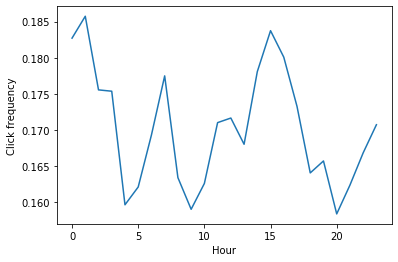

In [0]:
plt.figure()
plt.plot(df.groupby(['hour']).mean()['click']); # Fill here for the influence of the hour
plt.xlabel('Hour')
plt.ylabel('Click frequency')
plt.show()

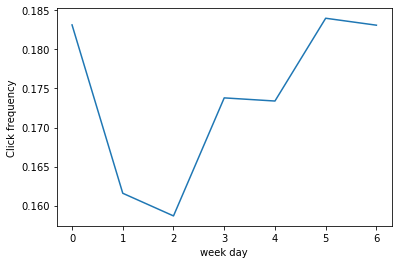

In [0]:
plt.figure()
plt.plot(df.groupby(['weekday']).mean()['click']); # Fill here for the influence of the day
plt.xlabel('week day')
plt.ylabel('Click frequency')
plt.show()

# Preliminary work and first model

Start by understanding the features with few modalities:
'hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'.

<font color="red">**Question:**
    For instance, inspect the columns 'C15' (dimension of the advert) and 'site_category': visualize the clicks mean.
</font>

In [0]:
df.groupby(['C15']).mean()['click'] # Fill here: inspect 'C15' using '.groupby'

C15
120     0.033708
216     0.129612
300     0.360537
320     0.158767
480     0.285714
728     0.054144
768     0.375000
1024    0.166667
Name: click, dtype: float64

In [0]:
df.groupby(['site_category']).mean()['click'] # Fill here: inspect 'site_category' using '.groupby'

site_category
0569f928    0.053613
28905ebd    0.208076
335d28a8    0.089824
3e814130    0.284245
42a36e14    0.225806
50e219e0    0.128597
5378d028    0.000000
70fb0e29    0.144737
72722551    0.059172
75fa27f6    0.111305
76b2941d    0.035756
8fd0aea4    0.015873
9ccfa2ea    0.000000
a818d37a    0.000000
bcf865d9    0.000000
c0dd3be3    0.128655
c706e647    0.000000
da34532e    0.000000
dedf689d    0.530449
e787de0e    0.000000
f028772b    0.179719
f66779e6    0.034564
Name: click, dtype: float64

<font color="red">**Question:**
    Some site categories have a null click rate. Why? Display the 'count()' of each modality.
    <br><br>
    Hint: you can use the method ".value_counts()"
</font>

In [0]:
df.groupby(['site_category'])['click'].value_counts() # Fill here

site_category  click
0569f928       0           406
               1            23
28905ebd       0        144146
               1         37874
335d28a8       0          3050
               1           301
3e814130       0         54159
               1         21508
42a36e14       0            48
               1            14
50e219e0       0        356335
               1         52586
5378d028       0            11
70fb0e29       0           520
               1            88
72722551       0           636
               1            40
75fa27f6       0          3561
               1           446
76b2941d       0          2481
               1            92
8fd0aea4       0           186
               1             3
9ccfa2ea       0             5
a818d37a       0            81
bcf865d9       0            16
c0dd3be3       0           894
               1           132
c706e647       0             1
da34532e       0             1
dedf689d       1           331
               0  

It is practical to visualize both columns in parallel:

In [0]:
col = 'site_category'
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'count']
a.sort_values(by='count', ascending=False)

mean     count
site_category                    
50e219e0       0.128597  408921.0
f028772b       0.179719  313339.0
28905ebd       0.208076  182020.0
3e814130       0.284245   75667.0
f66779e6       0.034564    6365.0
75fa27f6       0.111305    4007.0
335d28a8       0.089824    3351.0
76b2941d       0.035756    2573.0
c0dd3be3       0.128655    1026.0
72722551       0.059172     676.0
dedf689d       0.530449     624.0
70fb0e29       0.144737     608.0
0569f928       0.053613     429.0
8fd0aea4       0.015873     189.0
a818d37a       0.000000      81.0
42a36e14       0.225806      62.0
e787de0e       0.000000      28.0
bcf865d9       0.000000      16.0
5378d028       0.000000      11.0
9ccfa2ea       0.000000       5.0
c706e647       0.000000       1.0
da34532e       0.000000       1.0

Your answer here

**Observation**: we observe that some sites don't have any click. That explains why the click rate is null for these sites.

<font color="red">**Question:**
    Divide the dataset into a training and test set with sklearn (use the following options: test_size=0.1, random_state=100).
    <br>
    Warning: do not use 'id' as a feature.
</font>

In [0]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['id', 'click'])
y = df['click']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=100)

# First work on a reduced number of features

<font color="red">**Question:**
    Put in a list the selected columns: 'hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'.
</font>

In [0]:
some_columns = ['hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 
                'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21']

<font color="red"> - Importer CategoricalEncoder de sklearn.preprocessing.  
- Fitter le CategoricalEncoder sur les données de train restreintes aux colonnes ci-dessus.  
- Transformer les données de train et de test en dummies.
</font>

<font color="red">**Question:**
    <br>
    - Import OneHotEncoder from sklearn.preprocessing
    <br>
    - Transform the training and the test data restricted to the selected columns
</font>

In [0]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore').fit(Xtrain[some_columns])
Xtrain_oh = ohe.transform(Xtrain[some_columns]) # fit the transformation of Xtrain restricted to selected columns
Xtest_oh = ohe.transform(Xtest[some_columns]) # and transform Xtest restricted to selected columns

<font color="red">**Question:**
    What is the new number of features?
</font>

In [0]:
Xtrain_oh.shape[1]

183

Your answer here

There are 183 features.

<font color="red">**Question:**
    Visualize the first row of the design matrix you have got. Do not forget to convert it into a "numpy.array" using the method ".toarray()".
</font>

In [0]:
Xtrain_oh.toarray()[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

<font color="red">**Question:**
    Import and fit a logistic regression model on your the encoded data.
</font>

In [0]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=100)
lr.fit(Xtrain_oh, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=100, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

<font color="red">**Question:**
    With '.predict' and 'predict_proba', display the hard and soft decision you get on test data.
</font>

In [0]:
hard = lr.predict(Xtest_oh)
soft = lr.predict_proba(Xtest_oh)[:, 1]

<font color="red">**Question:**
    Compute the probability of error using sklearn.metrics 'accuracy_score' function. Comment.
</font>

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, hard) # Fill here

0.83043

Your answer here

The accuracy score isn't bad, but beware: the dataset is unbalacend. We should look at other metrics, like the area under the log loss, or the area under the ROC curve.   

<font color="red">**Question:**
    Plot the ROC curve. Then compute the log loss and the Area Under the Curve ROC.
</font>

Text(0.5, 1.0, 'ROC curve')

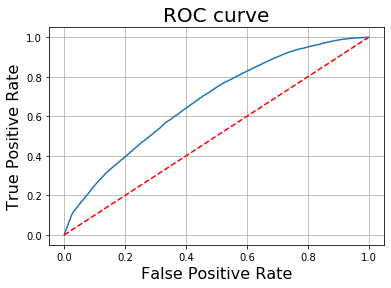

In [0]:
from sklearn.metrics import roc_curve

false_pos_rate, true_pos_rate, _ = roc_curve(ytest, soft)
plt.plot(false_pos_rate, true_pos_rate)

plt.grid()
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=20)

In [0]:
from sklearn.metrics import log_loss , roc_auc_score

log_loss(ytest, soft), roc_auc_score(ytest, soft)

(0.42512042343317613, 0.6762982820621418)

<font color="red">**Question:**
    Import the 'plot_lift' function from 'utils.py' and plot the lift curve. What is the lift of the first fifth of the population identified by the test?
</font>

[]

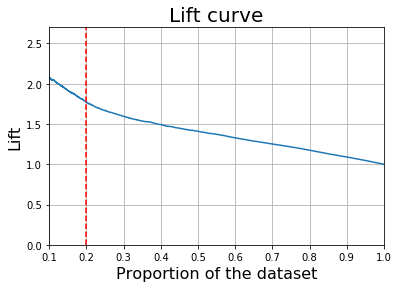

In [0]:
from utils import plotlift

plotlift(ytest, soft)
# The following line just plots a vertical line for you to answer the second part of the question
plt.axvline(x=0.2, linestyle='--', color='r') # Fill here

plt.xlabel('Proportion of the dataset', fontsize=16)
plt.ylabel('Lift', fontsize=16)
plt.title('Lift curve', fontsize=20)
plt.plot()

Your answer here

The lift of the first fifth of the population identified by the test is around ~1.75.

# Complete model

As an example, we now focus on the 'site_id' column.

<font color="red">**Question:**
    <br>
    - For each modality, compute the number of occurrences in the dataset and the average of clicks for this modality 
    <br>
    - With 'sns.joiplot', represent the set of points (count, mean) for each modality
</font>

In [0]:
import seaborn as sns

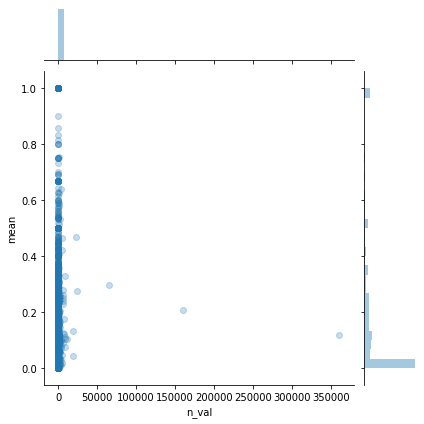

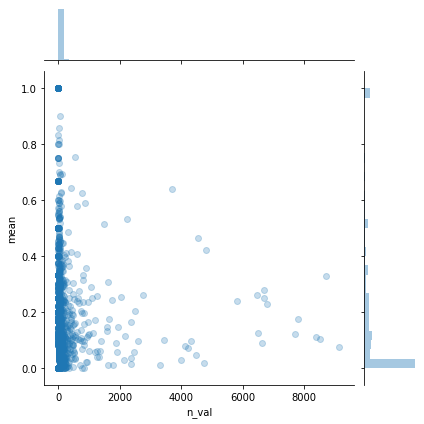

In [0]:
col = 'site_id'
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'n_val']
sns.jointplot(a['n_val'], a['mean'], alpha=0.25);
thres = 10000
sns.jointplot(a[a['n_val']<thres]['n_val'], a[a['n_val']<thres]['mean'], alpha=0.25);

<font color="red">**Question:**
    In the above commands, what does the alpha parameter stand for?
</font>

Your answer here

The alpha parameter stands for the opacity value of the points. Therefore higher opacity actually means that many points overlap.

Several sites with a lot of occurrences in the dataset have a click frequency very different from the mean. It is relevant to keep the column 'site_id' at least for the modalities for which 'count' is very high.

<font color="red">**Question:**
    Do the same work on the 'device_id' column. What do you notice? What could be the isolated point?
</font>

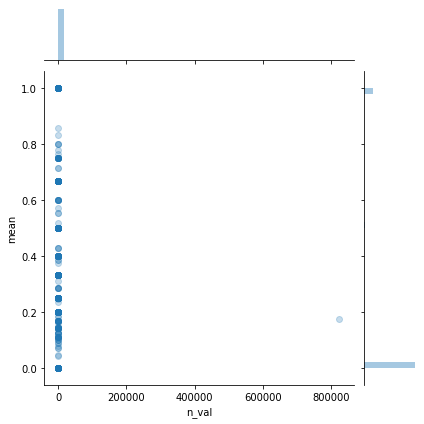

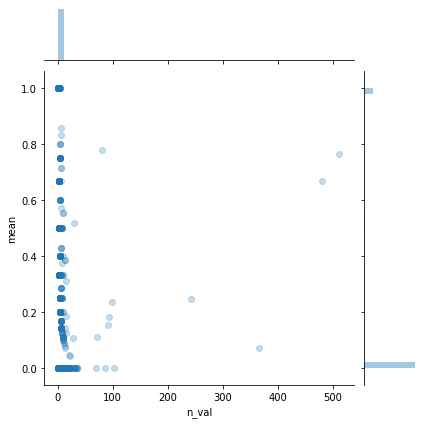

In [0]:
col = 'device_id' # Fill here
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'n_val']
sns.jointplot(a['n_val'], a['mean'], alpha=0.25);
thres = 10000
sns.jointplot(a[a['n_val']<thres]['n_val'], a[a['n_val']<thres]['mean'], alpha=0.25);

Your answer here

The unique spot values corresponds to people whose device hide or block the users information. The website associates a standard ID to all these users. That's why the unique spot value have a big n value.

<font color="red">**Question**:   
    In the column df['device_id'], spot the value V corresponding to the largest number of 'count' (using '.value_counts' method). Create a new column df['user'] defined as follows:
</font>
$$
\text{user} = \left\{\begin{array}[h]{ll} \text{device_ip + device_model} & \text{if device_id = V}\\ \text{device_id} & \text{else.}\end{array}\right.
$$

In [0]:
V = df['device_id'].value_counts().idxmax() # Fill here

df['user'] = (df['device_ip'] + df['device_model']) * (df['device_id']==V) + df['device_id'] * (df['device_id']!=V)

<font color="red">**Question**:
    Drop the following columns: 'device_id', 'device_model' and 'device_ip'
</font>

In [0]:
df = df.drop(columns=['device_id', 'device_model', 'device_ip'])

<font color="red">**Question**:
    One could look at the similarity between 'site_id' and 'site_domain'. Merge those columns into a new 'site' column (using the '+' operator)  and delete the old 'site_id' and 'site_domain' columns.
</font>

In [0]:
df['site'] = df['site_id'] + df['site_domain']
df = df.drop(columns=['site_id', 'site_domain'])

<font color="red">**Question**:
    Once again, split the modified DataFrame 'df' into a train and a test set (with options: test_size=0.1 and random_state=100).
    <br>
    Warning: do not use 'id' as a feature.
</font>

In [0]:
X = df.drop(columns=['id', 'click'])
y = df['click']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=100)

In [0]:
Xtrain.shape

(900000, 20)

<font color="red">**Question**:
    Define a OneHotEncoder and then, 'fit_transform' the train set.
</font>

In [0]:
ohe = OneHotEncoder(handle_unknown='ignore')
Xtrain_oh = ohe.fit_transform(Xtrain) # Fill here

<font color="red">**Question**:
    Transform the test set. If an error occurs, analyze it and try to solve it by modifying the parameter "handle_unkown" of the OneHotEncoder. 
    <br>
    Explain your the problem you encouter and how you solved it. 
</font>

In [0]:
Xtest_oh = ohe.transform(Xtest) # Fill here

Your answer here

The test dataset could have some categorical features that the train data set doesn't know after fitting on the train set. We ignore these features.

<font color="red">**Question**:
    What is the new number of features?
</font>

In [0]:
Xtrain_oh.shape[1]

713334

Your answer here

The new number of features is 713334

<font color="red">**Question**:
    How many modalities have been seen more than a 100 times?
</font>

In [0]:
# The following 'n_ones' vector below gives the number of '1' in each column/modality of the Xtrain_oh design matrix.
n_ones = np.array(Xtrain_oh.sum(axis=0))

nb_useful_modalities = sum(np.array(n_ones>100)[0]) # Fill here using 'n_ones'
print(nb_useful_modalities)

1971


Your answer here

1971 have been seen more than 100 times.

The list 'cols_to_keep' below is used to store the indices of the modalities seen more than a 100 times. 

<font color="red">**Question**:
    How does the `enumerate` function work?
</font>

In [0]:
useful = np.array(n_ones>100)[0]
cols_to_keep = [i for i,b in enumerate(useful) if b]

Your answer here

Enumerate() method adds a counter to an iterable. Here we can store the index of a column with the counter, if the column is specified as "usefull".

<font color="red">**Question**:
    Using only our restriction on the 'cols_to_keep' columns, retrain a logistic regression model and compare its performance in terms of 'log_loss' and 'roc_auc_curve'.
</font>

In [0]:
lr = LogisticRegression()
lr.fit(Xtrain_oh[:, cols_to_keep], ytrain)
hard = lr.predict(Xtest_oh[:, cols_to_keep])
soft = lr.predict_proba(Xtest_oh[:, cols_to_keep])[:, 1]

print(accuracy_score(ytest, hard)) # Fill here
print(log_loss(ytest, soft), roc_auc_score(ytest, soft))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.83373
0.40115384962973016 0.7385969297244755


# Gradient Boosting Decision Trees

<font color="red">**Question**:
    <br>
    - Import GradientBoostingClassifier from scikit learn. 
    <br>
    - Initialize it using 50 estimators and a learning rate of 0.8. Set 'verbose=True' to monitor the progress of the training step.
    <br>
    - Fit it on the same columns 'cols_to_keep' of Xtrain_oh than for the previous logistic regression.
    <br>
    - Evaluate its performance as in the previous step.
</font>

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.8, verbose=True) # Fill here

In [0]:
gb.fit(Xtrain_oh[:, cols_to_keep], ytrain)

      Iter       Train Loss   Remaining Time 
         1           0.8743            4.03m
         2           0.8646            3.87m
         3           0.8583            3.83m
         4           0.8535            3.71m
         5           0.8503            3.65m
         6           0.8464            3.55m
         7           0.8441            3.49m
         8           0.8418            3.43m
         9           0.8404            3.36m
        10           0.8383            3.26m
        20           0.8282            2.42m
        30           0.8234            1.61m
        40           0.8190           48.35s
        50           0.8163            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.8, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=True,
                           warm_start=False)

In [0]:
soft = gb.predict_proba(Xtest_oh[:, cols_to_keep])[:, 1]
log_loss(ytest, soft), roc_auc_score(ytest, soft)

(0.40916235348642266, 0.7252328290988748)

<font color="red">**Question**:
    What does the 'gb.estimators_' output?
</font>

In [0]:
gb.estimators_

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort='auto',
                      random_state=RandomState(MT19937) at 0x7F96E630FA98,
                      splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort='auto',
                      random_state=RandomState(MT19937) at 0x7F96E630FA98,
                      splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, max_features=None,
        

Your answer here

gb.estimators_ outputs the final list of all the estimators of each boosting stage after training.

We now try to use the 'gb' classifier to generate features that will be relevant inputs for the logistic regression.

<font color="red">**Question**:
    With the 'gb.apply()' method, generate a transformation 'leafs_train' of the training set 'Xtrain_oh[:, cols_to_keep]' for which the n-th column corresponds to the number of the leaf returned by the estimator n.
</font>

In [0]:
# Test here the gb.apply method on Xtrain[:, cols_to_keep]
leafs_train = gb.apply(Xtrain_oh[:, cols_to_keep])
leafs_test = gb.apply(Xtest_oh[:, cols_to_keep])

After your applied gb.apply on Xtrain_oh[:, cols_to_keep], remember that we have only one class to predict (click = 0 or 1). So, do not forget to slice your output with [:, :, 0] in order to keep, firstly, all the samples, and secondly all your 50 estimators.

Hint: you can have a look at the dimensions of your output with .shape !

In [0]:
leafs_train = pd.DataFrame(leafs_train[:, :, 0]) # Fill here
leafs_test = pd.DataFrame(leafs_test[:, :, 0])

<font color="red">**Question**:
    Encode these new features into dummies.
</font>

In [0]:
ohe = OneHotEncoder() # Fill here an argument if needed
leafs_train_oh = ohe.fit_transform(leafs_train) # Fill here
leafs_test_oh = ohe.transform(leafs_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


<font color="red">**Question**:
    With the "hstack" function, create a new matrix of features by concatenating horizontally our new features "leafs_train_oh" and "leafs_test_oh", and previous features used for logistic regression (e.g. in "Xtrain_oh[:, cols_to_keep]").
</font>
<br><br>
**Remark**: we use "hstack" from scipy.sparse (and not from numpy) because the output of our OneHotEncoder is a sparse array. You can verify it with the command "type(Xtrain_oh)".

In [0]:
from scipy.sparse import csr_matrix, hstack

Xtrain_concat = hstack([Xtrain_oh[:, cols_to_keep], leafs_train_oh]) # Fill here
Xtest_concat = hstack([Xtest_oh[:, cols_to_keep], leafs_test_oh])

<font color="red">**Question**:
    Run a logistic regression on the new features and evaluate its performance as before. 
    <br>
    Warning: be patient, fitting should take about 5 minutes on Google Colab.
</font>

In [0]:
lr = LogisticRegression(random_state=100)
lr.fit(Xtrain_concat, ytrain)
hard = lr.predict(Xtest_concat)
soft = lr.predict_proba(Xtest_concat)[:, 1]

print(accuracy_score(ytest, hard)) # Fill here
print(log_loss(ytest, soft), roc_auc_score(ytest, soft))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.83404
0.39994382201821915 0.7417501720272122


<font color="red">**Question**:
    <br>
    - Import XGBClassifier from xgboost package.
    <br>
    - Initialize it using the same number of estimators and learning rate as before. Set the 'n_jobs' to -1.
    <br>
    - Fit it on the same columns 'cols_to_keep' of Xtrain_oh than for the previous logistic regression.
    <br>
    - Evaluate its performance and compare it to the GradientBoosting classifier of scikit learn. How is the error? Does it take more time to run?
</font>

In [0]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=50, learning_rate=0.8, n_jobs=-1, verbosity=2)
%time xgb.fit(Xtrain_oh[:, cols_to_keep], ytrain)

hard = xgb.predict(Xtest_oh[:, cols_to_keep])
soft = xgb.predict_proba(Xtest_oh[:, cols_to_keep])[:, 1]

print(accuracy_score(ytest, hard)) # Fill here
print(log_loss(ytest, soft), roc_auc_score(ytest, soft))

[15:41:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:41:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:41:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:41:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:41:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:41:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:41:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:41:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nod

<font color="red">**Question**:
    Increase the number of estimators and visualize the impact on performance. You might have to adapt the learning rate. On Google Colab, here are the approximate training times<br> 
    - nb_estimators=256  and lr=0.8 ~  4 min<br>
    - nb_estimators=512  and lr=0.6 ~  8 min<br>
    - nb_estimators=1024 and lr=0.5 ~ 16 min
</font>

In [0]:
xgb = XGBClassifier(n_estimators=256, learning_rate=0.8, n_jobs=-1)
%time xgb.fit(Xtrain_oh[:, cols_to_keep], ytrain)

hard = xgb.predict(Xtest_oh[:, cols_to_keep])
soft = xgb.predict_proba(Xtest_oh[:, cols_to_keep])[:, 1]

print(accuracy_score(ytest, hard)) # Fill here
print(log_loss(ytest, soft), roc_auc_score(ytest, soft))

CPU times: user 4min 8s, sys: 265 ms, total: 4min 8s
Wall time: 1min 6s
0.83391
0.40059393350575 0.739887335347806


# Features hashing and random forest

We restart with raw features before dummy encoding: Xtrain, Xtest.

<font color="red">**Question**:
    Display again the number of modalities per feature in Xtrain. Use '.nunique()'
</font>

In [0]:
# Fill here
Xtrain.nunique()

hour                    24
C1                       7
banner_pos               7
site_category           22
app_id                3054
app_domain             196
app_category            26
device_type              5
device_conn_type         4
C14                   2225
C15                      8
C16                      9
C17                    420
C18                      4
C19                     66
C20                    163
C21                     60
weekday                  7
user                701585
site                  5442
dtype: int64

We want to define a transformation which regroups the least frequent modalities into a label 'isRare'. In order to do so, we decide to define our own Transformer.

<font color="red">**Question**:
    Understand the different steps of 'fit' and 'transform'.
</font>

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class MergeRareTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, col_names, threshold):
        self.col_names = col_names
        self.threshold = threshold

    def fit(self, X, y=None):

        X = pd.DataFrame(X)
        counts_dict_list = []
        ################## READ THIS #########################
        for i in range(len(self.col_names)):
            
            serie = X[self.col_names[i]].value_counts()  # Série des counts de chaque modalité
            rare_indexes = serie[serie<self.threshold[i]].index  # A quoi correspondent ces indices ?
            frequent_indexes = serie[serie>=self.threshold[i]].index  # A quoi correspondent ces indices ?
            dico = {x:'isRare' for x in rare_indexes}
            dico.update({x: str(x) for x in frequent_indexes})
            counts_dict_list.append(dico)   # Quel est le dictionnaire obtenu ?
            
        ######################################################
            
        self.counts_dict_list_ = counts_dict_list
        return self

    def transform(self, X):

        Xt = pd.DataFrame()
        ################## READ THIS #########################
        for col, count_dict in zip(self.col_names, self.counts_dict_list_):
            Xt[col] = X[col].apply(lambda x:count_dict[x] if x in count_dict else 'isRare')
            # A quoi sert le "else 'isRare'" dans la transformation de la colonne ?
        ######################################################

        return Xt


<font color="red">**Question:**
    <br>
    - Fit and transform the training set. To do so, merge all mmodalities occuring at least 20 times in each column.
    <br>
    - Transform the test set.
</font>

In [0]:
mg = MergeRareTransformer(col_names=Xtrain.columns, threshold=[20]*len(Xtrain.columns))
Xtrain_mg = mg.fit_transform(Xtrain) # Fill here with fit_transform
Xtest_mg = mg.transform(Xtest)

<font color="red">**Question:**
   How many elements of the column Xtrain_mg['app_domain'] are now labeled as 'rare'? Use the '.value_counts()' method.
</font>

In [0]:
# Fill here
Xtrain_mg['app_domain'].value_counts()

7801e8d9    606390
2347f47a    116467
ae637522     41928
5c5a694b     25289
82e27996     16869
d9b5648e     15709
0e8616ad     14784
b9528b13     14284
b8d325c3     11953
aefc06bd      6644
df32afa9      6412
33da2e74      5911
6f7ca2ba      4990
5b9c592b      2448
885c7f3f      1468
5c620f04      1419
45a51db4      1219
b5f3b24a      1093
813f3323       544
0654b444       514
isRare         513
ad63ec9b       388
c6824def       306
15ec7f39       275
a8b0bf20       266
99b4c806       219
828da833       185
448ca2e3       167
f2f777fb       157
43cf4f06       149
47464e95        99
d6feb1a4        95
2b627705        89
1ea19ec4        72
db829551        69
6a0a3a9d        59
18eb4e75        56
0d79ee56        53
9ec164d3        51
e5d5313f        46
b12ff13e        42
27ee373d        36
b408d42a        30
5ac0b939        28
1ed56ded        27
bb6bcbae        27
3feeed1e        26
63f57be0        25
15c23f8e        25
7eec2ab0        24
7a9371fa        21
dcdba109        20
afdf1f54    

<font color="red">**Question:**
   In the new train set, display the number of modalities for each feature.
</font>

In [0]:
# Fill here
Xtrain_mg.nunique()

hour                  24
C1                     7
banner_pos             7
site_category         18
app_id               613
app_domain            53
app_category          19
device_type            5
device_conn_type       4
C14                 1339
C15                    8
C16                    9
C17                  381
C18                    4
C19                   63
C20                  148
C21                   60
weekday                7
user                 901
site                 889
dtype: int64

Modalities are arbitrary object, such as '234', 'isRare', etc. We will now transorm them into integers with the hashing trick.

<font color="red">**Question:**
   To better understand how the 'hash' function is working, apply it to a string of your choice.
</font>

In [0]:
import hashlib
hash('test_string') # Fill here

-8946049807052614811

<font color="red">**Question:**
   Create two new datasets 'Xtrain_ha' and 'Xtest_ha' containing the output of the hashing process. Use the '.apply' method to transform iteratively the columns by mapping to each value its remainder in the euclidean division of the hash by 1000000. 
   Example:
</font>
</font>
<p>
<center>
2060777048690<font color="red">918393</font>  -->  918393
</center>
Remark: do not forget that the function 'hash' has to take a string as input.

In [0]:
Xtrain_ha = pd.DataFrame()
Xtest_ha = pd.DataFrame()
for col in Xtrain_mg.columns:
    Xtrain_ha[col] = Xtrain_mg[col].apply(lambda x: hash(str(x)) % 1000000) # Fill here defining a lambda function
    Xtest_ha[col] = Xtest_mg[col].apply(lambda x: hash(str(x)) % 1000000)

<font color="red">**Question:**
   Visualize the content of the DataFrames you have obtained.
</font>

In [0]:
# Fill here
Xtrain_ha

hour      C1  banner_pos  ...  weekday    user    site
92438   901254  884293      335895  ...   558659  408680  629937
60898   956935  180464      558659  ...   335895  408680  629937
556199  701460  180464      558659  ...   558659  408680  983396
193129  493025  180464      335895  ...   335895  408680  175022
231985  146915  180464      558659  ...   133139  408680  696605
...        ...     ...         ...  ...      ...     ...     ...
864087   68033  180464      335895  ...   652693  408680  821414
778087  493025  180464      558659  ...   335895  408680  629937
210755  344007  180464      558659  ...   685078  408680  718182
56088    42674  180464      335895  ...   685078  408680  605188
824840  133139  180464      558659  ...   335895  408680  696605

[900000 rows x 20 columns]

<font color="red">**Question:**
    <br>
    - Train a RandomForestClassifier on Xtrain_ha and evaluate its performance on Xtest_ha. Chose 256 estimators, min_samples_leaf=20 and verbose=1 in order to monitor the fitting step. (If you have enough time, try later with 1024 estimators and min_samples_leaf=20).
    <br>
    - How do you fix 'n_jobs'? 
</font>

In [0]:
from sklearn.ensemble import RandomForestClassifier # Fill here
rf = RandomForestClassifier(n_estimators=256, min_samples_leaf=20, verbose=1, n_jobs=-1)
rf.fit(Xtrain_ha, ytrain)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  4.0min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=256,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [0]:
soft = rf.predict_proba(Xtest_ha)[:, 1]
log_loss(ytest, soft), roc_auc_score(ytest, soft)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    2.5s finished


(0.40078070984989944, 0.7415469395064065)

<font color="red">**Question:**
   Compare with xgboost performance on the same hashed dataset, with n_estimators=256, n_jobs=-1, learning_rate=1.0. (If you have enough time try n_estimators=1024, n_jobs=-1, learning_rate=0.5, it will perform better than a Random Forest of 1024 trees).
</font>

In [0]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=256, learning_rate=0.1, n_jobs=-1) # Fill here

%time xgb.fit(Xtrain_ha, ytrain) # the '%time' command will return the execution time of the fitting step

soft = xgb.predict_proba(Xtest_ha)[:, 1]
log_loss(ytest, soft), roc_auc_score(ytest, soft)

CPU times: user 5min 20s, sys: 184 ms, total: 5min 20s
Wall time: 1min 20s


(0.41259298133645206, 0.7158785168205304)

<font color="red">**Question:**
    Plot the ROC and the lift curves for the obtained classifier (xgboost on hashed data). What is the lift of the first fifth of the population identified by the test?
</font>

Text(0.5, 1.0, 'ROC curve')

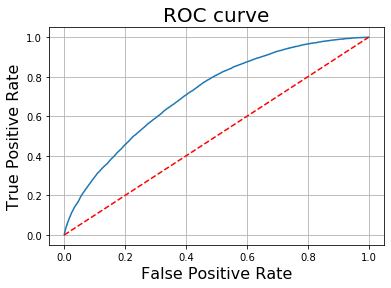

In [0]:
# Plot the ROC curve here
false_pos_rate, true_pos_rate, _ = roc_curve(ytest, soft)
plt.plot(false_pos_rate, true_pos_rate)

plt.grid()
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=20)

[]

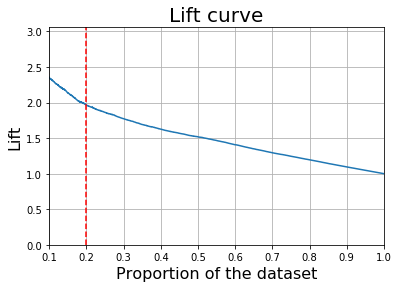

In [0]:
# Plot the lift curve here
plotlift(ytest, soft)
# The following line just plots a vertical line for you to answer the second part of the question
plt.axvline(x=0.2, linestyle='--', color='r') # Fill here

plt.xlabel('Proportion of the dataset', fontsize=16)
plt.ylabel('Lift', fontsize=16)
plt.title('Lift curve', fontsize=20)
plt.plot()

Your answer here

With this technique, the lift is now around ~2 for the fisrt fifth of the population.

Hashing produces columns of integers arbitrarily ordered. One can wonder if adding more columns hashed in a different fashion would lead to better performance. 

<font color="red">**Question:**
    Add hashed columns by recursively hashing the previous ones: complete the following code. 
</font>

In [0]:
Xtrain_haha = pd.DataFrame(Xtrain_ha).copy()
Xtest_haha = pd.DataFrame(Xtest_ha).copy()

n_hash = 3
cols = Xtrain_ha.columns
for l in range(n_hash):
    for col in cols:
        Xtrain_haha[col + '-hash'] = Xtrain_haha[col].apply(lambda x: hash(str(x)) % 1000000)
        Xtest_haha[col + '-hash'] = Xtest_haha[col].apply(lambda x: hash(str(x)) % 1000000)
    cols = [col + '-hash' for col in cols]

<font color="red">**Question:**
    Evaluate the performance of a random forest and/or an xgboost clasifier (chose 256 estimators first and learning rate of 1.0 for xgboost) on these enlarged dataset. Is the performance better than when hasing features once?
</font>

In [0]:
# Fill here
rf = RandomForestClassifier(n_estimators=256, min_samples_leaf=20, verbose=1, n_jobs=-1)
rf.fit(Xtrain_haha, ytrain)

soft = rf.predict_proba(Xtest_haha)[:, 1]
log_loss(ytest, soft), roc_auc_score(ytest, soft)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  6.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    3.3s finished


(0.39896424062958946, 0.7442141109942513)

In [0]:
# Fill here
xgb = XGBClassifier(n_estimators=256, learning_rate=0.1, n_jobs=-1) # Fill here

%time xgb.fit(Xtrain_haha, ytrain) # the '%time' command will return the execution time of the fitting step

soft = xgb.predict_proba(Xtest_haha)[:, 1]
log_loss(ytest, soft), roc_auc_score(ytest, soft)

CPU times: user 15min 30s, sys: 1.49 s, total: 15min 31s
Wall time: 3min 55s


(0.40894882679702715, 0.725239541045734)

Your answer here

After multiple hashing, the log loss is smaller and we obtained a larger area under the ROC curve: the performance has been improved!

Good job! :-) 

<font color="red">**Bonus Question:**
    If you have enough time (about 2 hours ...), try to fit both random forest and xgboost models with 1024 estimators (and a learning rate of 0.5 for xgboost) on these enlarged datasets.<br>
    - Which one performs better?<br> 
    - Can you see the improvement due to the addition of more hashed features?
</font>

In [0]:
# Fill here

# Field-aware Factorization Machines
<br>
<font color="red">
Display the names of the columns of the matrix Xtrain_ha
</font>

In [0]:
Xtrain_ha.columns

Index(['hour', 'C1', 'banner_pos', 'site_category', 'app_id', 'app_domain',
       'app_category', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'weekday', 'user', 'site'],
      dtype='object')

<font color="red">
Create a list of lists of the columns. The n-th sub-list is composed of the names of the columns of the n-th field.</font>

In [0]:
fields = []
fields.append(['hour', 'weekday'])
fields.append(['banner_pos', 'C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'])
fields.append(['app_id', 'app_domain', 'app_category'])
fields.append(['user', 'device_type', 'device_conn_type'])
fields.append(['site', 'site_category'])


<font color="red">
With the enumerate function, let generate a dictionary which associates each column name with its field.


In [0]:
dicFields = { name_col : i  for i,f in enumerate(fields) for name_col in f}

We need to make sure that two different columns have different modalities. For this, we add in front of each modality a characteristic string of the column.

<font color="red">Perform this transformation with the apply method</font>


In [0]:
Xtrain_ffm = pd.DataFrame()
Xtest_ffm = pd.DataFrame()
for col in Xtrain_ha.columns:
    Xtrain_ffm[col] = Xtrain_ha[col].apply(lambda x: hash(col)%10000 + x)
    Xtest_ffm[col] = Xtest_ha[col].apply(lambda x: hash(col)%10000 + x)

With np.unique, we create the list of all the modalities appearing in all the columns.

In [0]:
allvals = []
allcols_ffm = [col for f in fields for col in f]  # Toutes les colonnes appartenant à l'un des champ
for col in allcols_ffm:
    allvals.append(np.unique(Xtrain_ffm[col]))
allvals= [val for sublist in allvals for val in sublist]

<font color="red">
Using enumerate method, create a dictionary that at each value associates its rank in the allvals list.</font>

In [0]:
dicFeat = {val:i for i,val in enumerate(allvals)}

We build dataframe from dicFeat as follows:
in each "col" column, the value "x" is replaced by the string "f: v: 1", where f is the field associated with the column and v is the index of the modality x.
<font color="red">
Study the following code</font>

In [0]:
for col in allcols_ffm:
    f = dicFields[col]
    Xtrain_ffm[col] = Xtrain_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")
    Xtest_ffm[col] = Xtest_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")

<font color="red">For the two resulting dataframes, concatenate on the left the corresponding ytrain (or ytest) click column</font>

In [0]:
yXtrain_ffm = pd.concat([ytrain.apply(str), Xtrain_ffm] , axis=1)
yXtest_ffm = pd.concat([ytest.apply(str), Xtest_ffm], axis=1)

<font color="red">What does the following cell produce?</font>

In [0]:
train_w = yXtrain_ffm.apply(lambda row:' '.join(row.values),axis=1).values
test_w = yXtest_ffm.apply(lambda row:' '.join(row.values),axis=1).values
len(train_w), len(test_w)

(900000, 100000)

<font color="red">Write the above dataframe in a text file</font>

In [0]:
%cd '/content/gdrive/My Drive/Colab Notebooks/tp_avazu/notebooks/libffm-master/'

/content/gdrive/My Drive/Colab Notebooks/tp_avazu/notebooks/libffm-master


In [0]:
train_file = open('train.txt','w')
for item in train_w:
    train_file.write("%s\n" % item)
train_file.close()

# Faire de même pour le test set
test_file = open('test.txt','w')
for item in test_w:
    test_file.write("%s\n" % item)
test_file.close()

To learn the FFM model, we use the LibFFM library https://www.csie.ntu.edu.tw/~cjlin/libffm/
In the notebooks / directory there are two executables: ffm-train and ffm-predict.
In jupyter notebook, the exclamation point! allows to launch a bash command.
The use is as follows:

-   `ffm-train'

    usage: ffm-train [options] training_set_file [model_file]

    options:  
    -l <lambda>: set regularization parameter (default 0.00002)  
    -k <factor>: set number of latent factors (default 4)  
    -t <iteration>: set number of iterations (default 15)  
    -r <eta>: set learning rate (default 0.2)  
    -s <nr_threads>: set number of threads (default 1)  
    -p <path>: set path to the validation set  
    --quiet: quiet model (no output)  
    --no-norm: disable instance-wise normalization  
    --auto-stop: stop at the iteration that achieves the best validation loss (must be used with -p)  
<br>
<font color="red">Learn the model. We can :
- use an regularizer of 0.00001
- use a learning rate of 0.05
- use of the order of 15 latent factors
- carry out the order of 30 iterations
- with the -p option, change the test file to validation parameters
- activate the --autostop mode
</font> 

In [0]:
!chmod u+x ./ffm-train
!./ffm-train -l 0.00001 -r 0.05 -k 15 -t 30 --auto-stop -p test.txt train.txt model.txt

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (4.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.5 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.41002      0.40354          4.7
   2      0.40249      0.40047          9.4
   3      0.40047      0.39907         13.8
   4      0.39927      0.39886         18.3
   5      0.39840      0.39797         22.7
   6      0.39777      0.39750         27.1
   7      0.39721      0.39715         31.5
   8      0.39669      0.39701         35.9
   9      0.39631      0.39682         40.3
  10      0.39593      0.39669         44.7
  11      0.39560      0.39655         49.1
  12      0.39527      0.39644         53.5
  13      0.39499      0.39632         57.9
  14      0.39470      0.39627         62.3
  15      0.39446      0.3

The use of ffm-predict is: ffm-predict filename-test file-name-model file-in-which-write-the-prediction 
<font color="red">Perform the prediction</font>

In [0]:
!chmod u+x ./ffm-predict
!./ffm-predict test.txt model.txt prediction.txt

logloss = 0.39604




```
# Ce texte est au format code
```

<font color="red">Compute the log_loss and area under the roc curve (ROC AUC).</font>

In [0]:
ffm_pred = pd.read_csv('./prediction.txt', header=None)
ypred_ffm_soft = ffm_pred.values

In [0]:
log_loss(ytest, ypred_ffm_soft), roc_auc_score(ytest, ypred_ffm_soft)

(0.3960355836758428, 0.7495094915826116)

# Blending

<font color="red">
Split Xtrain in two: Xtrain_meth and Xtrain_blend.</font>

In [0]:
Xtrain_meth, Xtrain_blend, ytrain_meth, ytrain_blend = train_test_split(Xtrain,ytrain,test_size=0.2)

<font color="red">
Train a logistic regression on XTrain_meth. Then compute its score on Xtrain_blend and save the score in a vector.</font>

In [0]:
# we re-use the 'cols to keep' that we found in the 'complete model' part
# To do so, we one hot encode with the same ohe fit on the total Xtrain set
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(Xtrain)

Xtrain_meth_oh = ohe.transform(Xtrain_meth)
Xtrain_blend_oh = ohe.transform(Xtrain_blend)
Xtest_oh = ohe.transform(Xtest)

lr = LogisticRegression()
lr.fit(Xtrain_meth_oh[:, cols_to_keep], ytrain_meth)

score_blend_logistic = lr.predict_proba(Xtrain_blend_oh[:, cols_to_keep])[:, 1]
score_test_logistic = lr.predict_proba(Xtest_oh[:, cols_to_keep])[:, 1]

print(log_loss(ytrain_blend, score_blend_logistic), roc_auc_score(ytrain_blend, score_blend_logistic))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.40228090735320776 0.7353545831900072


<font color="red">
Do the same thing with XGBoost (save the score).</font>

In [0]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=256, learning_rate=0.8, n_jobs=-1)
%time xgb.fit(Xtrain_meth_oh[:, cols_to_keep], ytrain_meth)

score_blend_xgb = xgb.predict_proba(Xtrain_blend_oh[:, cols_to_keep])[:, 1]
score_test_xgb = xgb.predict_proba(Xtest_oh[:, cols_to_keep])[:, 1]

print(log_loss(ytrain_blend, score_blend_xgb), roc_auc_score(ytrain_blend, score_blend_xgb))

CPU times: user 3min 13s, sys: 753 ms, total: 3min 14s
Wall time: 52.3 s
0.40212903818241835 0.7365877656126009


<font color="red">
Do the same with a RandomForest (save the score).</font>

In [0]:
from sklearn.ensemble import RandomForestClassifier

# To improve performance of the model, we use the same feature engineering process we used in the feature hashing part
Xtrain_meth_mg = mg.fit_transform(Xtrain_meth)
Xtrain_blend_mg = mg.fit_transform(Xtrain_blend)
Xtest_mg = mg.transform(Xtest)

Xtrain_meth_ha = pd.DataFrame()
Xtrain_blend_ha = pd.DataFrame()
Xtest_ha = pd.DataFrame()
for col in Xtrain_mg.columns:
    Xtrain_meth_ha[col] = Xtrain_meth_mg[col].apply(lambda x: hash(str(x)) % 1000000)
    Xtrain_blend_ha[col] = Xtrain_blend_mg[col].apply(lambda x: hash(str(x)) % 1000000)
    Xtest_ha[col] = Xtest_mg[col].apply(lambda x: hash(str(x)) % 1000000)

# Random Forest classifier
rf = RandomForestClassifier(n_estimators=256, min_samples_leaf=20, verbose=1, n_jobs=-1)
rf.fit(Xtrain_meth_ha, ytrain_meth)

score_blend_rf = rf.predict_proba(Xtrain_blend_ha)[:, 1]
score_test_rf = rf.predict_proba(Xtest_ha)[:, 1]

log_loss(ytrain_blend, score_blend_rf), roc_auc_score(ytrain_blend, score_blend_rf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  2.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    2.2s finished


(0.4021488973698389, 0.7374994662928884)

<font color="red">
Now with an extraTrees.</font>

In [0]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=256, min_samples_leaf=20, random_state=0)
clf.fit(Xtrain_meth_ha, ytrain_meth)

score_blend_extra_tree = clf.predict_proba(Xtrain_blend_ha)[:, 1]
score_test_extra_tree = clf.predict_proba(Xtest_ha)[:, 1]

log_loss(ytrain_blend, score_blend_extra_tree), roc_auc_score(ytrain_blend, score_blend_extra_tree)

(0.4070060895481567, 0.7289730710879477)

<font color="red">
And again with FFM.</font>

In [0]:
# We are going through the same process than in the FFM part (doing everything again to avoid executing the full notebook).
Xtrain_meth_ffm = pd.DataFrame()
Xtrain_blend_ffm = pd.DataFrame()
Xtest_ffm = pd.DataFrame()
for col in Xtrain_meth_ha.columns:
    Xtrain_meth_ffm[col] = Xtrain_meth_ha[col].apply(lambda x: hash(col)%10000 + x)
    Xtrain_blend_ffm[col] = Xtrain_blend_ha[col].apply(lambda x: hash(col)%10000 + x)
    Xtest_ffm[col] = Xtest_ha[col].apply(lambda x: hash(col)%10000 + x)

allvals = []
allcols_ffm = [col for f in fields for col in f]  # Toutes les colonnes appartenant à l'un des champ
for col in allcols_ffm:
    allvals.append(np.unique(Xtrain_meth_ffm[col]))
allvals= [val for sublist in allvals for val in sublist]

dicFeat = {val:i for i,val in enumerate(allvals)}

for col in allcols_ffm:
    f = dicFields[col]
    Xtrain_meth_ffm[col] = Xtrain_meth_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")
    Xtrain_blend_ffm[col] = Xtrain_blend_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")
    Xtest_ffm[col] = Xtest_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")

yXtrain_meth_ffm = pd.concat([ytrain_meth.apply(str), Xtrain_meth_ffm] , axis=1)
yXtrain_blend_ffm = pd.concat([ytrain_blend.apply(str), Xtrain_blend_ffm] , axis=1)
yXtest_ffm = pd.concat([ytest.apply(str), Xtest_ffm], axis=1)

train_meth_w = yXtrain_meth_ffm.apply(lambda row:' '.join(row.values),axis=1).values
train_blend_w = yXtrain_blend_ffm.apply(lambda row:' '.join(row.values),axis=1).values
test_w = yXtest_ffm.apply(lambda row:' '.join(row.values),axis=1).values

In [0]:
train_meth_file = open('train_meth.txt','w')
for item in train_meth_w:
    train_meth_file.write("%s\n" % item)
train_meth_file.close()

train_blend_file = open('train_blend.txt','w')
for item in train_blend_w:
    train_blend_file.write("%s\n" % item)
train_blend_file.close()

final_test_file = open('final_test.txt','w')
for item in test_w:
    final_test_file.write("%s\n" % item)
final_test_file.close()

In [0]:
len(train_meth_w), len(train_blend_w), len(test_w)

(720000, 180000, 100000)

In [0]:
!./ffm-train -l 0.0001 -r 0.05 -k 15 -t 30 --auto-stop -p final_test.txt train_meth.txt model_blend.txt

First check if the text file has already been converted to binary format (0.3 seconds)
Binary file found. Skip converting text to binary
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.5 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.41297      0.40629          3.9
   2      0.40522      0.40368          7.5
   3      0.40319      0.40293         11.1
   4      0.40204      0.40221         14.7
   5      0.40127      0.40177         18.3
   6      0.40069      0.40165         21.9
   7      0.40022      0.40152         25.5
   8      0.39984      0.40123         29.1
   9      0.39956      0.40113         32.7
  10      0.39930      0.40102         36.3
  11      0.39905      0.40093         39.9
  12      0.39884      0.40082         43.5
  13      0.39862      0.40085
Auto-stop. Use model at 12th iteration.


In [0]:
!./ffm-predict train_blend.txt model_blend.txt prediction_blend.txt

logloss = 0.40129


In [0]:
!./ffm-predict final_test.txt model_blend.txt prediction_test.txt

logloss = 0.40082


In [0]:
ffm_blend_pred = pd.read_csv('./prediction_blend.txt', header=None)
ffm_test_pred = pd.read_csv('./prediction_test.txt', header=None)

score_blend_ffm = ffm_blend_pred.values.ravel()
score_test_ffm = ffm_test_pred.values.ravel()

log_loss(ytrain_blend, score_blend_ffm), roc_auc_score(ytrain_blend, score_blend_ffm)

(0.40128969877253023, 0.738248261818606)

<font color="red">
Concatenate all scores on Xtrain_blend to form a Zblend design matrix.</font>

In [0]:
Zblend = np.column_stack((score_blend_logistic,
                          score_blend_xgb,
                          score_blend_rf,
                          score_blend_extra_tree,
                          score_blend_ffm))

Ztest = np.column_stack((score_test_logistic,
                         score_test_xgb,
                         score_test_rf,
                         score_test_extra_tree,
                         score_test_ffm))

Zblend.shape, Ztest.shape

((180000, 5), (100000, 5))

<font color="red">
Train a logistic regression on (Zblend,ytrain_blend).</font>

In [0]:
lr = LogisticRegression()
lr.fit(Zblend, ytrain_blend)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

<font color="red">
Evaluate the performance of this model on the test dataset.</font>

In [0]:
final_score_test = lr.predict_proba(Ztest)[:, 1]

print(log_loss(ytest, final_score_test), roc_auc_score(ytest, final_score_test))

0.4044433700520764 0.744022886416385


Text(0.5, 1.0, 'ROC curve')

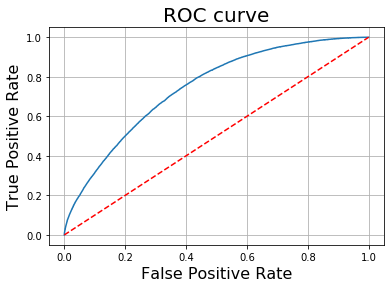

In [0]:
from sklearn.metrics import roc_curve

false_pos_rate, true_pos_rate, _ = roc_curve(ytest, final_score_test)
plt.plot(false_pos_rate, true_pos_rate)

plt.grid()
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=20)

[]

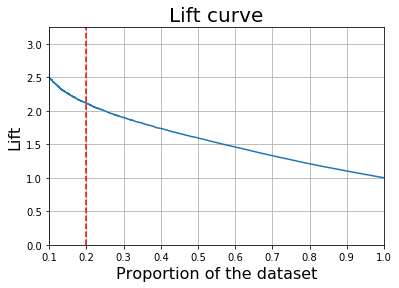

In [0]:
from utils import plotlift

plotlift(ytest, final_score_test)
# The following line just plots a vertical line for you to answer the second part of the question
plt.axvline(x=0.2, linestyle='--', color='r') # Fill here

plt.xlabel('Proportion of the dataset', fontsize=16)
plt.ylabel('Lift', fontsize=16)
plt.title('Lift curve', fontsize=20)
plt.plot()